In [1]:
from pymongo import MongoClient
import pprint
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

db=MongoClient()["comic"]

# 요일별 웹툰 
좋아요평균

In [2]:
webtoons=db["webtoons"]

pipeline=[
    {
        '$unwind': {
            'path': '$dayrank'
        }
    }, {
        '$group': {
            '_id': '$dayrank.day', 
            'totalLike': {
                '$sum': '$likeIt'
            }, 
            'totalWebtoons': {
                '$sum': 1
            }
        }
    }, {
        '$set': {
            'weekday': '$_id', 
            'avgLike': {
                '$divide': [
                    '$totalLike', '$totalWebtoons'
                ]
            }
        }
    }, {
        '$project': {
            'weekday': 1, 
            'avgLike': 1, 
            '_id': 0
        }
    }
]

plist = list(webtoons.aggregate(pipeline))

df=pd.DataFrame(plist)
df

,weekday,avgLike
0,fri,180965.958333
1,wed,169281.549020
2,sun,111100.857143
3,tue,185206.500000
4,mon,176405.450980
5,sat,155627.562500
6,thu,173260.255319


In [3]:
df=df.reindex([5,0,6,4,2,3,1]) # 아니 이거 실행할때마다 순서 바뀌는데 value정보로 정렬못하나??
df

,weekday,avgLike
5,sat,155627.562500
0,fri,180965.958333
6,thu,173260.255319
4,mon,176405.450980
2,sun,111100.857143
3,tue,185206.500000
1,wed,169281.549020


<BarContainer object of 7 artists>

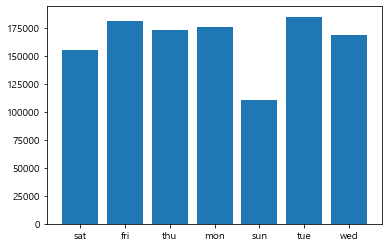

In [4]:
fig, ax = plt.subplots()

ax.bar(list(df.weekday), list(df.avgLike))

# 주 2회 연재 만화 보기

In [5]:
pipeline=[
    {
        '$match': {
            '$expr': {
                '$gt': [
                    {
                        '$size': '$dayrank'
                    }, 1
                ]
            }
        }
    }, {
        '$set': {
            'day': '$dayrank.day'
        }
    }, {
        '$project': {
            'title': 1, 
            'day': 1, 
            '_id': 0
        }
    }
]

plist=list(webtoons.aggregate(pipeline))

df=pd.DataFrame(plist)
df

,title,day
0,모죠의 일지,"[wed, sat]"
1,유미의 세포들,"[wed, sat]"
2,데이빗,"[thu, sun]"
3,닥터앤닥터 육아일기,"[wed, sun]"
4,사소한 냐냐,"[mon, thu]"
5,패밀리 사이즈,"[tue, sun]"
6,윌유메리미,"[tue, sat]"
7,삼국지톡,"[tue, fri]"


# 장르로 묶었을 때
장르로 묶었을 때
스토리, 에피소드, 옴니버스 별 작품수

In [6]:
webtoons=db['webtoons']

pipeline=[
    {
        '$unwind': {
            'path': '$genre'
        }
    }, {
        '$match': {
            'genre': {
                '$in': [
                    '스토리', '에피소드', '옴니버스'
                ]
            }
        }
    }, {
        '$group': {
            '_id': '$genre', 
            'amount': {
                '$sum': 1
            }, 
            'like': {
                '$sum': '$likeIt'
            }
        }
    }, {
        '$set': {
            'avgLike': {
                '$divide': [
                    '$like', '$amount'
                ]
            }, 
            'title': '$_id'
        }
    }, {
        '$project': {
            '_id': 0, 
            'avgLike': 1, 
            'title': 1,
            'amount':1
        }
    }
]

plist=list(webtoons.aggregate(pipeline))

df=pd.DataFrame(plist)
df

,amount,avgLike,title
0,13,154522.769231,옴니버스
1,289,155670.961938,스토리
2,32,220220.406250,에피소드


In [15]:
webtoons=db['webtoons']

pipeline=[
    {
        '$unwind': {
            'path': '$genre'
        }
    }, {
        '$match': {
            'genre': {
                '$in': [
                    '스토리', '에피소드', '옴니버스'
                ]
            }
        }
    }, {
        '$lookup': {
            'from': 'episodes', 
            'localField': 'titleId', 
            'foreignField': 'titleId', 
            'as': 'episodes'
        }
    }, {
        '$unwind': {
            'path': '$episodes'
        }
    }, {
        '$group': {
            '_id': '$genre', 
            'amount': {
                '$sum': 1
            }, 
            'comments': {
                '$sum': '$episodes.totalComment'
            }
        }
    }, {
        '$set': {
            'avgComment': {
                '$divide': [
                    '$comments', '$amount'
                ]
            }, 
            'title': '$_id'
        }
    }, {
        '$sort':{
            'amount':-1
        }
    }, {
        '$project': {
            '_id': 0, 
            'title': 1, 
            'avgComment': 1
        }
    }
]

plist=list(webtoons.aggregate(pipeline))

avgCommentData=pd.DataFrame(plist)
avgCommentData


,avgComment,title
0,1004.104714,스토리
1,1785.956229,에피소드
2,601.353846,옴니버스


In [8]:
df['avgComment']=avgCommentData['avgComment']

df=df[['title', 'amount', 'avgLike', 'avgComment']]
df['avgLike']=df['avgLike'].round(2)
df['avgComment']=df['avgComment'].round(2)
df

,title,amount,avgLike,avgComment
0,옴니버스,13,154522.77,601.35
1,스토리,289,155670.96,1004.10
2,에피소드,32,220220.41,1785.96


In [9]:
webtoons=db['webtoons']

pipeline=[
    {
        '$match': {
            'genre': '스토리'
        }
    }, {
        '$unwind': {
            'path': '$genre'
        }
    }, {
        '$group': {
            '_id': '$genre', 
            'sum': {
                '$sum': 1
            }
        }
    }, {
        '$set': {
            'genre': '$_id'
        }
    }, {
        '$project': {
            '_id': 0
        }
    }, {
        '$match': {
            'genre': {
                '$nin': [
                    '$genre', '스토리'
                ]
            }
        }
    }, {
        '$sort': {
            'sum': -1
        }
    }
]

plist=list(webtoons.aggregate(pipeline))

s_df=pd.DataFrame(plist)
s_df

,sum,genre
0,77,드라마
1,57,로맨스
2,57,판타지
3,41,스릴러
4,36,액션
5,9,개그
6,6,스포츠
7,3,감성
8,3,시대극


In [10]:
webtoons=db['webtoons']

pipeline=[
    {
        '$match': {
            'genre': '에피소드'
        }
    }, {
        '$unwind': {
            'path': '$genre'
        }
    }, {
        '$group': {
            '_id': '$genre', 
            'sum': {
                '$sum': 1
            }
        }
    }, {
        '$set': {
            'genre': '$_id'
        }
    }, {
        '$project': {
            '_id': 0
        }
    }, {
        '$match': {
            'genre': {
                '$nin': [
                    '$genre', '에피소드'
                ]
            }
        }
    }, {
        '$sort': {
            'sum': -1
        }
    }
]

plist=list(webtoons.aggregate(pipeline))

e_df=pd.DataFrame(plist)
e_df

,sum,genre
0,9,드라마
1,6,일상
2,6,개그
3,4,로맨스
4,3,액션
5,2,스릴러
6,1,판타지
7,1,시대극


In [11]:
webtoons=db['webtoons']

pipeline=[
    {
        '$match': {
            'genre': '옴니버스'
        }
    }, {
        '$unwind': {
            'path': '$genre'
        }
    }, {
        '$group': {
            '_id': '$genre', 
            'sum': {
                '$sum': 1
            }
        }
    }, {
        '$set': {
            'genre': '$_id'
        }
    }, {
        '$project': {
            '_id': 0
        }
    }, {
        '$match': {
            'genre': {
                '$nin': [
                    '$genre', '옴니버스'
                ]
            }
        }
    }, {
        '$sort': {
            'sum': -1
        }
    }
]

plist=list(webtoons.aggregate(pipeline))

o_df=pd.DataFrame(plist)
o_df

,sum,genre
0,6,스릴러
1,3,드라마
2,2,판타지
3,1,일상
4,1,개그


In [14]:
df['title'][0]

'옴니버스'

In [12]:
# Make data: I have 3 groups and 7 subgroups
group_names=[df['title'][0], df['title'][1], df['title'][2]]
group_size=[df['amount'][0], df['amount'][1], df['amount'][2]]
subgroup_names=[]
for g in s_df['genre']:
    subgroup_names.append(g)
for g in e_df['genre']:
    subgroup_names.append(g)
for g in o_df['genre']:
    subgroup_names.append(g)
subgroup_size=[]
for n in s_df['sum']:
    subgroup_size.append(n)
for n in e_df['sum']:
    subgroup_size.append(n)
for n in o_df['sum']:
    subgroup_size.append(n)

# Create colors
a, b, c=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
mypie_color=[]
for i in range(1, len(s_df['genre'])+1):
    mypie_color.append(a(0.1*i))
for i in range(1, len(e_df['genre'])+1):
    mypie_color.append(a(0.1*i))
for i in range(1, len(o_df['genre'])+1):
    mypie_color.append(a(0.1*i))

# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors= 
[a(0.6), b(0.6), c(0.6)] )
plt.setp( mypie, width=0.3, edgecolor='white')

# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, 
labels=subgroup_names, labeldistance=0.7, colors=mypie_color)
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

plt.legend(loc=(0.9, 0.1))
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[3:], subgroup_names_legs, loc=(0.9, 0.1))
plt.show()

ValueError: 'label' must be of length 'x'